# LearnLab Summer School CER Track
## Student Code Analysis
Yang Shi (yang.shi@usu.edu, personal website: https://yshi.info/)

### Pre: Doer effect:
The "doer effect" is the assertion that the amount of interactive practice activity a student engages in is much more predictive of learning than the amount of passive reading or watching video the same student engages in.

Koedinger, Kenneth R., Richard Scheines, and Peter Schaldenbrand. "Is the Doer Effect Robust across Multiple Data Sets?." EDM 2018.

**So, are you ready to be a doer?** Hopefully you'll get some chance of working on your own data after this!

Note: From my experiences, for some of you this will be super fast, and very slow for the others.

Main references:

[1] Shi, Y., Shah, K., Wang, W., Marwan, S., Penmetsa, P., & Price, T. (2021, April). Toward semi-automatic misconception discovery using code embeddings. In LAK21: 11th International Learning Analytics and Knowledge Conference (pp. 606-612).

[2] Shi, Y., Mao, Y., Barnes, T., Chi, M., & Price, T. W. (2021). More with Less: Exploring How to Use Deep Learning Effectively through Semi-Supervised Learning for Automatic Bug Detection in Student Code. International Educational Data Mining Society.

[3] Shi, Y., Chi, M., Barnes, T., & Price, T. W. (2022). Code-DKT: A Code-Based Knowledge Tracing Model for Programming Tasks. International Educational Data Mining Society.

[4] Shi, Y., Schmucker, R., Chi, M., Barnes, T., & Price, T. (2023). KC-Finder: Automated Knowledge Component Discovery for Programming Problems. International Educational Data Mining Society.

[5] Shi, Y., Schmucker, R., Tran, K., Bacher, J., Koedinger, K., Price, T., Chi, M., & Barnes, T. (2024). The Knowledge Component Attribution Problem for Programming: Methods and Tradeoffs with Limited Labeled Data. Journal of Educational Data Mining, 16(1), 1-33.

# Introduction and Necessary Packages (10 mins)



Welcome to the hands-on session of CER code analysis! 👋

**Learing Goal:** In this section you will learn a set of methods to process the data that you collected from students' programming code.

**With this lecture you can:**
0.   Learn fundamental ways to extract features and use a simple machine leanring method to implement a classifier.
1.   Gain a basic understanding of neural networks that can be associated directly with implementations, which are the foundation of advanced AI.
2.   Learn structural representations of programming code and use a simple attention mechanism for analysis.
3.   Implement end-to-end neural networks using PyTorch.

**This lecture does not include:**

1.   The process of collecting data and initial processing. -- Thomas has covered the part.
2.   How exactly generative AI work and how to directly apply the content of this lecture to a LLM. -- This is likely the frontier of research in AI
3.   How to perform tuning/finetuning or prompt engineering. -- Hopefully some other activities will get you more experiences on these topics.



Before you start to collect your data, let start with an example dataset and work on a project to build an autograder to take a peek in the world of data-driven analysis on students' code.

**CodeWorkout 19 Spring Dataset**

[Link to dataset (requires registration to Datashop).](https://pslcdatashop.web.cmu.edu/Files?datasetId=3458)

To save time, let's mount from my Google Drive. The data is stored in the [ProgSnap2](https://cssplice.github.io/progsnap2/) format. While more details are available in the website, we will be using a processed subset today.

In [1]:
# Import necessary libraries
import pandas as pd
import math
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

maintable_url = 'https://drive.google.com/uc?export=download&id=1l-sVHE2VQuTfhzMXAdcu9lDO1yur14cO'
codestates_url = 'https://drive.google.com/uc?export=download&id=1gkE44n8hiDTLLdJx0KbdA8RWz9ExN5DO'
maintable_df = pd.read_csv(maintable_url)
codestates_df = pd.read_csv(codestates_url)


Mounted at /content/drive


In [3]:
# View of main table. Columns we will be using are:
# CodeStateID: ID of code submission.
# Score: Whether students are correct or not, percentage of test cases the submission pass.
maintable_df.head()

,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,Order,ParentEventID
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Run.Program,1.0,NaN,NaN,NaN,11161,11161,NaN
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:43:31,0,CS 1,439,1,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,True,Compile,NaN,Success,NaN,NaN,11162,11162,11161.0
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Run.Program,0.0,NaN,NaN,NaN,11163,11163,NaN
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile,NaN,Error,NaN,NaN,11164,11164,11163.0
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,Java 8; CodeWorkout,2019-09-27T12:46:46,0,CS 1,439,3,53e05b92cf3e024e5b8c4858d8e02ccd724e1283d53cde...,True,Compile.Error,NaN,NaN,SyntaxError,line 3: error: cannot find symbol: variable Ou...,11165,11165,11164.0


In [4]:
# View of code state table. Columns we will be using are:
# CodeStateID: ID of code submission.
# Code: The actual code submission of students.
codestates_df.head()

,CodeStateID,Code
0,e03c3817ba234c667140a5281960bfc79238ef075b48c7...,"public int caughtSpeeding(int speed, boolean i..."
1,cdfe99579672f04db808aa7343826bf3c71751dfba129d...,"public int caughtSpeeding(int speed, boolean i..."
2,511eeec6958a4d834c7419dc55b4831655b13aa6d343ac...,"public int caughtSpeeding(int speed, boolean i..."
3,4c09d5ddc005e6104a8f58f76ee1020eb0adc109b13cb0...,"public int caughtSpeeding(int speed, boolean i..."
4,71514451fe4c010093a06f9f58eced6ae9de98a13edae7...,"public int caughtSpeeding(int speed, boolean i..."


In [5]:
# Some necessary processing
maintable_df = maintable_df[maintable_df['EventType'] == 'Run.Program'] # Keep one instance per submission
maintable_prob1_df = maintable_df[maintable_df['ProblemID'] == 1] # We only work on the first problem in this hands-on lecture
data_df = maintable_prob1_df[['CodeStateID', 'Score']].merge(codestates_df, on='CodeStateID', how='left') # Merging tables and only keep score as labels.
data_df['Score'] = data_df['Score'].apply(math.floor) # A submission is correct only if it passes all test cases.

Before we run into the models, we should also split the data into training and testing

**Note**: Typically we should have a validation dataset to validate our hyperparameters, we simplify this process here to focus on the models and structures.

In [6]:
# Split the dataset into training and testing with a 4:1 ratio.
train_df, test_df = train_test_split(data_df, test_size=0.2)

Let's see how the training data frame look like.

In [7]:
len(train_df)

989

## Preliminary Data Analysis


<Axes: ylabel='Code'>

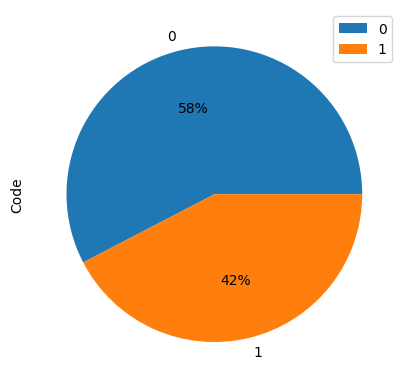

In [8]:
# Plotting a pie chart of score distribution
train_df.groupby(['Score']).count().plot(kind='pie', y='Code', autopct='%1.0f%%')

### **Discussion**: What will happen if scores are not balanced? What does that mean?

# Vectorization and Neural Network (30 mins)

In this section, we will learn how to represent programming code into vectors. We will learn basic methods such as tf-idf, and 1-hot vector representations.

## 2.1 Code Representation and Simple Vectorization

Programming code in our data looks like this:

In [9]:
print(train_df['Code'].iloc[0])

public int sortaSum(int a, int b)
{
    if ( (a+b) > 9 && (a+b) < 20 )
    {
        return 20;
    }
    else
    {
        return a+b;
    }
}



While most data-driven AI models need numerical representations, text code cannot directly serve as the input. We need to use numbers to represent such text for the algorithms.

While there are many methods available, one simple way to achieve the goal is to **count** the "tokens" in input. This may sound a bit sketchy, but let's start with this method.

To achieve the vectorization work, we leverage [sklearn package](https://scikit-learn.org/stable/). This package includes many practical tools for data process and classical machine learning tasks.

In [10]:
# Import corresponding package
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# Practice

# Initiate a count vectorizer object
count_vectorizer = CountVectorizer()
# Fitting the training dataset and transform it
X_train = count_vectorizer.fit_transform(train_df['Code'])

# Check the shape of the array
print(X_train.toarray().shape)
# Check the names of the features
print(count_vectorizer.get_feature_names_out())

# Apply the vectorizer to the test dataset
X_test = count_vectorizer.transform(test_df['Code'])

# Process ground truth
y_train = train_df['Score']
y_test = test_df['Score']

(989, 70)
['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '190' '20' '21' '30'
 'abs' 'absum' 'add' 'adigit' 'allow' 'and' 'ans' 'bdigit' 'between'
 'boolean' 'break' 'class' 'else' 'false' 'for' 'givensum' 'if' 'int'
 'integer' 'is' 'math' 'mysum' 'new' 'num' 'number' 'numbers' 'of'
 'offset' 'or' 'otherwise' 'out' 'pmz' 'println' 'private' 'public'
 'range' 'result' 'results' 'ret' 'retun' 'return' 'sortasum' 'static'
 'sum' 'sume' 'sumemup' 'summ' 'sumofab' 'sumvalue' 'system' 'teensum'
 'the' 'total' 'true' 'value' 'void']


In [12]:
# Build a simple machine learning algorithm to classify and test
# We use logistic regression as an example
from sklearn.linear_model import LogisticRegression

# Train a model of logistic regression
clf = LogisticRegression().fit(X_train, y_train)
# Print the accuracy score of the model
print(clf.score(X_test, y_test))

0.625


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Why counting sounds too simple? For example, in the first problem, we probably can observe "if" used no matter whether the code is correct or not. However, if a student require the usage of "println", they likely to make a mistake of not returning the results properly. To account for this property, people developed the TF-IDF method.

**TF (term frequency)**: The number of times a term show up in a code submission.

**IDF (inverse document frequency)**: Document frequency means the total document numbers a term show up, it is the inversed number of the term.

A term "if" could have both high TF and DF, yielding small differences between correct and incorrect submissions. However, "println" may have a high TF for incorrect submissions, and the DF should be relatively low. This will result a high TF-IDF value in incorrect submissions and low TF-IDF value in correct submissions.

Will this complication help us?

In [13]:
# Import corresponding package
from sklearn.feature_extraction.text import TfidfVectorizer

# Initiate a tfidf vectorizer object
tfidf_vectorizer = TfidfVectorizer()
# Fitting the training dataset and transform it
X_train = tfidf_vectorizer.fit_transform(train_df['Code'])

# Apply the vectorizer to the test dataset
X_test = tfidf_vectorizer.transform(test_df['Code'])

# Train a model of logistic regression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# Print the accuracy score of the model
print(clf.score(X_test, y_test))

0.5846774193548387


## 2.2 Neural Network with PyTorch

### Concept of Neural Networks

Not going to delve too much into the math, but let's play with the demo by tensorflow.

[A demo from Google Tensorflow](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.17985&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

### PyTorch: Tensors and Layers

**Tensor**: Identical to numpy arrays. It represents a multi-dimentional array.

**Layer**: Neural networks are comprised of layers to make operations on data.

In [14]:
# Practice
# Simple tensor operations
import torch

# Putting data into a tensor
train_tensor = torch.Tensor(X_train.toarray())
test_tensor = torch.Tensor(X_test.toarray())

# Print the data type of tensors
print(train_tensor.dtype)
# Slicing of tensors
print(test_tensor[0,1])
print(test_tensor[0,:])
print(train_tensor.shape)

torch.float32
tensor(0.)
tensor([0.2356, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2492, 0.0000, 0.2256, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3008,
        0.0000, 0.0000, 0.0000, 0.2173, 0.6434, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2145, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.4324, 0.2166, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([989, 70])


In [15]:
# Practice
# Simple layers
import torch.nn as nn

# A linear (hidden) layer with the shape of feature size to 1.
linear_layer = nn.Linear(train_tensor.shape[1],1)
# Activation layer of sigmoid
sigmoid_layer = nn.Sigmoid()

# Pass the training data to the two layers
out = sigmoid_layer(linear_layer(train_tensor))
print(out.size())

torch.Size([989, 1])


In [16]:
# Let's turn the two layers into a simple 1-hidden-layer neural network!

# Using super to use the net like a layer (inherit nn.Module)
class SimpleNet(nn.Module):
    def __init__(self, input_shape):
        super(SimpleNet, self).__init__()
        # Define the layers of the network
        # We need two linear layers and a sigmoid layer
        hidden = 64

        self.input_layer = nn.Linear(input_shape, hidden)
        self.hidden_layer = nn.Linear(hidden, 1)
        self.sigmoid_layer = nn.Sigmoid()
    def forward(self, input):
        # Given input, we need to pass the input through the layers
        return self.sigmoid_layer(self.hidden_layer(self.input_layer(input)))

In [17]:
# Let's run the network on training data!

model = SimpleNet(train_tensor.size()[1])
out = model(train_tensor)

print(out.shape)

torch.Size([989, 1])


### Loss Functions and Learning

Only one run cannot guide the network to learn -- what should we do to help it?

In neural networks, we use a loss function to guide the model to learn. PyTorch has convenient implementations to help the model training process.

References to check if you are curious how cross entropy or Adam optimizer work:

[Cross Entropy Read](https://en.wikipedia.org/wiki/Cross_entropy)

[Adam Optimizer Read](https://arxiv.org/abs/1412.6980)

In [18]:
# Define the hyperparameters of model training
lr = 0.1 # Learning rate
epochs = 300 # Training epochs

# Initialize model
model = SimpleNet(train_tensor.size()[1])

# We use binary cross entropy as the loss
loss_func = nn.BCELoss()

# Using Adam as the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Putting labels in tensors
y_train = torch.Tensor(train_df['Score'].values)
y_test = torch.Tensor(test_df['Score'].values)

# Repeat the learning process for the number of epochs
for e in range(epochs):
    # Forward pass
    predictions = model(train_tensor)
    # Calculate the loss -- the squeeze ensures the dimensions are consistent
    loss = loss_func(torch.squeeze(predictions), y_train)

    # Model clean gradient
    optimizer.zero_grad()
    # Model backward pass to get the gradient
    loss.backward()
    # Model updating weights
    optimizer.step()

    # Print the training process
    if e % 20 == 0:
        print("Epoch:", e, "loss:", loss.item())


Epoch: 0 loss: 0.6921929121017456
Epoch: 20 loss: 0.611117959022522
Epoch: 40 loss: 0.6004855632781982
Epoch: 60 loss: 0.5921840667724609
Epoch: 80 loss: 0.5880057215690613
Epoch: 100 loss: 0.6289592385292053
Epoch: 120 loss: 0.5892898440361023
Epoch: 140 loss: 0.5853161811828613
Epoch: 160 loss: 0.5839202404022217
Epoch: 180 loss: 0.5831068754196167
Epoch: 200 loss: 0.5826734304428101
Epoch: 220 loss: 0.5906897187232971
Epoch: 240 loss: 0.5866392850875854
Epoch: 260 loss: 0.583044171333313
Epoch: 280 loss: 0.5826451182365417


In [19]:
# Evaluation on the Testing set
y_pred = model(test_tensor)

# We'll need to use sklearn's metric calculation to calculate the accuracy for
# test dataset.
from sklearn import metrics
test_accuracy = metrics.accuracy_score(y_pred.detach().numpy().round(), y_test)

print(test_accuracy)

0.6411290322580645


### **Discussion**: Where does this improvement of TF-IDF features come from?

## 2.3 N-Gram and LSTM for Autograding

We can still use more information of the code. Imagine a scenario, that every token/term has a weight to be considered for the prediction, and the weight is determined not only by the term, but also by the other terms in the submission.

To achieve this, we cannot simply count the frequency of terms -- we need to assign numbers to **each** of the terms.

But will this easily work?

### One-hot Encoding

Assume we have a dictionary, including all terms that show up in the training dataset, then they can be 1-1 represented as their index in the dictionary. By showing which element in a vector is labeled as "1", the corresponding term is turned into a vector.



In [20]:
# Let's first build a dictionary using the training dataset. To do so, we need
# a package: Gensim
import gensim

# Split the code from students using spaces and lines
text_tokens = [[t for t in code.split()] for code in train_df['Code']]
# Putting text tokens into a dictionary
D = gensim.corpora.Dictionary(text_tokens)
print(D)


Dictionary<440 unique tokens: ['&&', '(', '(a+b)', ')', '20']...>


In [21]:
# Now map the train dataset text into indices of the dictionary.

# Get a disctionary mapping of id
train_indices = [[D.token2id[t] for t in code.split()] for code in train_df['Code']]
test_indices = [[D.token2id[t] if t in D else len(D) for t in code.split()] for code in test_df['Code']]

In [22]:
# And one hot encode them using torch

# First pad the input to the same length as torch needs to process multi-
# dimensional vectors
from torch.nn.utils.rnn import pad_sequence
train_sequences = pad_sequence([torch.tensor(s) for s in train_indices],
                               batch_first=True, padding_value=len(D)+2)
test_sequences = pad_sequence([torch.tensor(s) for s in test_indices],
                               batch_first=True, padding_value=len(D)+2)

# PyTorch has a function to turn the indices into one-hot vectors
X_train = nn.functional.one_hot(train_sequences)
X_test = nn.functional.one_hot(test_sequences)

print(X_train.shape)
print(X_test.shape)

torch.Size([989, 115, 443])
torch.Size([248, 59, 443])


The vector has 989 code submissions, with the maximum length of submission has 115 tokens, and we use a 421-dimensional vector to 1-hot encode each of the token.

### Using Recurrent Neural Network (RNN) for Sequential Information

Recurrent Neural Network is frequently used in sequential information processing. It is a structure that considers prior input information when processing current tokens. Below is a figure from WikiPedia on how RNN works. 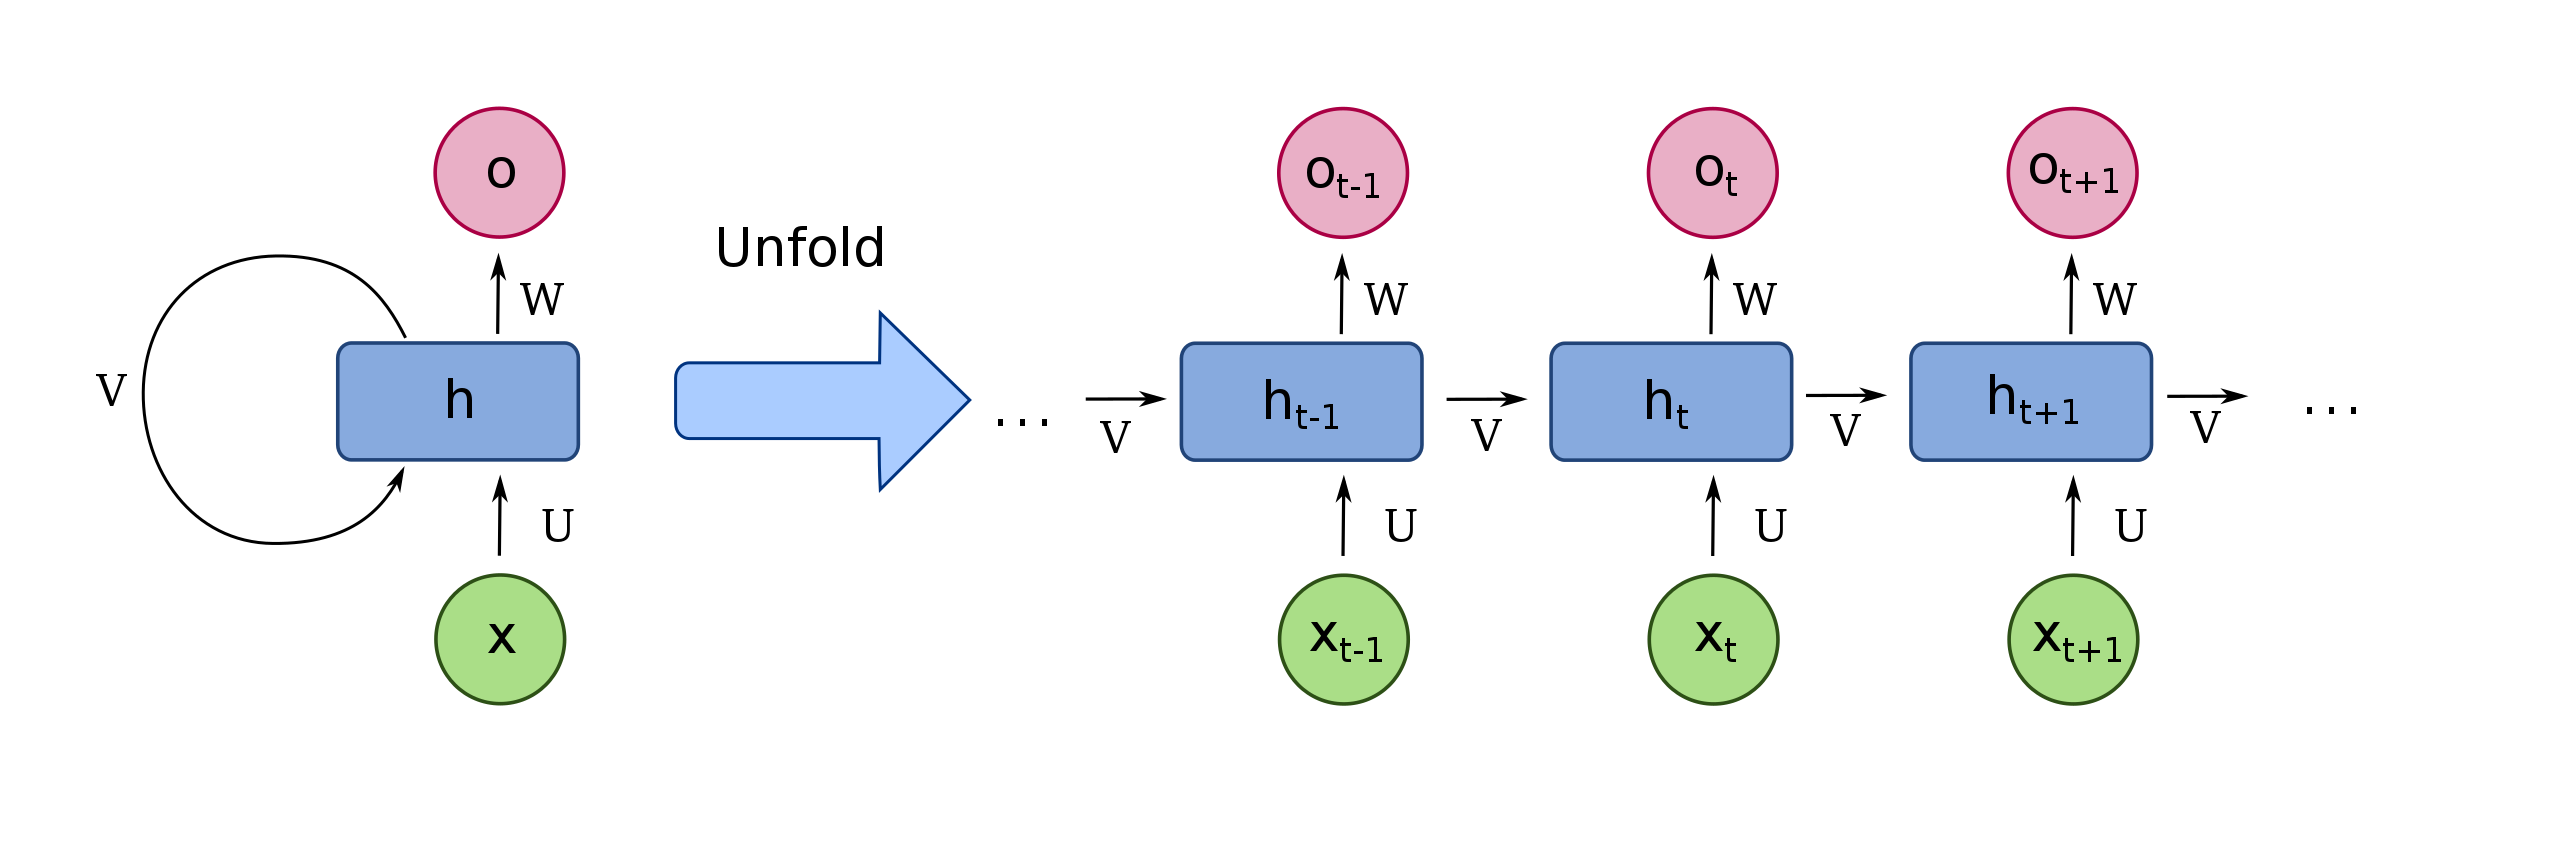

With a input sequence $[...,x_{i-2}, x_{i-1}, x_{i}, x_{i+1},...]$, the layer first uses a $U$ matrix to transform $x_t$, but instead of directly use the output as the hidden information, the hidden information has information from prior hidden information: $h_t = Ux_t+Vh_{t-1}$. Finally the $h_t$ is transformed by another parameter metric $W$ to get an output $O_t$ for every token input.

In [23]:
# Here is a simple implementation of the RNN model enabled by torch.

# Using super to use the net like a layer (inherit nn.Module)
class RNNNet(nn.Module):
    def __init__(self, input_shape):
        super(RNNNet, self).__init__()
        # Define the layers of the network
        self.hidden = 128
        # Define the rnn layer here -- it can be RNN or LSTM.
        self.rnn_layer = nn.LSTM(input_size=input_shape[-1],
                                hidden_size=self.hidden,
                                num_layers=1,
                                batch_first=True,
                                bidirectional=True)
        self.output_layer = nn.Linear(2*self.hidden, 1)
        self.sigmoid_layer = nn.Sigmoid()
    def forward(self, input):

        # Initiate hidden layer h_0
        hidden_init = torch.zeros(2, input.shape[0], self.hidden)

        # Run the RNN layer
        out, _ = self.rnn_layer(input)

        # Given input, we need to pass the input through the layers
        return self.sigmoid_layer(self.output_layer(out[:,-1,:]))

In [24]:
# Now let's try the RNN model!
# RNN requires some computing resource, so let's move to GPU.

# Define the hyperparameters of model training
lr = 0.01 # Learning rate
epochs = 100 # Training epochs

# Initialize model
model = RNNNet(X_train.size()).to("cuda:0")

# We use binary cross entropy as the loss
loss_func = nn.BCELoss()

# Using Adam as the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Putting labels in tensors
y_train = torch.Tensor(train_df['Score'].values)
y_test = torch.Tensor(test_df['Score'].values)

# Repeat the learning process for the number of epochs
for e in range(epochs):
    # Forward pass
    predictions = model(X_train.float().to("cuda:0"))
    # Calculate the loss -- the squeeze ensures the dimensions are consistent
    loss = loss_func(torch.squeeze(predictions), y_train.to("cuda:0"))

    # Model clean gradient
    optimizer.zero_grad()
    # Model backward pass to get the gradient
    loss.backward()
    # Model updating weights
    optimizer.step()

    # Print the training process
    if e % 20 == 0:
        print("Epoch:", e, "loss:", loss.item())


Epoch: 0 loss: 0.6898964643478394
Epoch: 20 loss: 0.680881917476654
Epoch: 40 loss: 0.6809736490249634
Epoch: 60 loss: 0.6808040738105774
Epoch: 80 loss: 0.6806654930114746


In [25]:
# Evaluation on the Testing set
y_pred = model(X_test.float().to("cuda:0"))

# We'll need to use sklearn's metric calculation to calculate the accuracy for
# test dataset.
test_accuracy = metrics.accuracy_score(y_pred.cpu().detach().numpy().round(),
                                       y_test)

print(test_accuracy)

0.6169354838709677


Still not making much difference (or even make it harder). Any other options we can try?

### N-Grams for Text Representation

What if we try to use the terms with grams? For example, 2-gram means two terms are indexed together.

In [26]:
# function for making ngrams
from nltk.util import ngrams

# Practice
# Split the code from students using spaces and lines
text_tokens = [[str(t) for t in ngrams(code.split(), 2)] for code in train_df['Code']]

In [27]:
# Putting text tokens into a dictionary
D = gensim.corpora.Dictionary(text_tokens)

# Get a disctionary mapping of id
train_indices = [[D.token2id[str(t)] for t in ngrams(code.split(), 2)] for code in train_df['Code']]
test_indices = [[D.token2id[str(t)] if str(t) in D else len(D) for t in ngrams(code.split(), 2)] for code in test_df['Code']]

# First pad the input to the same length as torch needs to process multi-
# dimensional vectors
train_sequences = pad_sequence([torch.tensor(s) for s in train_indices],
                               batch_first=True, padding_value=len(D)+2)
test_sequences = pad_sequence([torch.tensor(s) for s in test_indices],
                               batch_first=True, padding_value=len(D)+2)

# PyTorch has a function to turn the indices into one-hot vectors
X_train = nn.functional.one_hot(train_sequences)
X_test = nn.functional.one_hot(test_sequences)

print(X_train.shape)
print(X_test.shape)

torch.Size([989, 114, 1420])
torch.Size([248, 58, 1420])


In [28]:
# Define the hyperparameters of model training
lr = 0.01 # Learning rate
epochs = 100 # Training epochs

# Initialize model
model = RNNNet(X_train.size()).to("cuda:0")

# We use binary cross entropy as the loss
loss_func = nn.BCELoss()

# Using Adam as the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Putting labels in tensors
y_train = torch.Tensor(train_df['Score'].values)
y_test = torch.Tensor(test_df['Score'].values)

# Repeat the learning process for the number of epochs
for e in range(epochs):
    # Forward pass
    predictions = model(X_train.float().to("cuda:0"))
    # Calculate the loss -- the squeeze ensures the dimensions are consistent
    loss = loss_func(torch.squeeze(predictions), y_train.to("cuda:0"))

    # Model clean gradient
    optimizer.zero_grad()
    # Model backward pass to get the gradient
    loss.backward()
    # Model updating weights
    optimizer.step()

    # Print the training process
    if e % 20 == 0:
        print("Epoch:", e, "loss:", loss.item())

Epoch: 0 loss: 0.6935006976127625
Epoch: 20 loss: 0.6810430288314819
Epoch: 40 loss: 0.6898910403251648
Epoch: 60 loss: 0.7123546004295349
Epoch: 80 loss: 0.6850878000259399


In [29]:
# Evaluation on the Testing set
y_pred = model(X_test.float().to("cuda:0"))

# We'll need to use sklearn's metric calculation to calculate the accuracy for
# test dataset.
test_accuracy = metrics.accuracy_score(y_pred.cpu().detach().numpy().round(),
                                       y_test)

print(test_accuracy)

0.6169354838709677


### **Discussion:** Why do we have low performance still? How to address it?

https://app.sli.do/event/rsYMTC3xHpWW8s28vsTdMV/embed/polls/468d6667-5ce3-46b6-a552-89688bac5923


# Structural Analysis of Programming Code -- Using code2vec as an example (20 mins)

## 3.1 Code Path Representation and code2vec

### Programmming Code Representations: Abstract Syntax Tree (AST)

Programming code can be parsed into a tree structure. For example, the pseudocode below can be parsed into a tree:


```
while b ≠ 0:
    if a > b:
        a := a - b
    else:
        b := b - a
return a
```
(Example from Wikipedia)


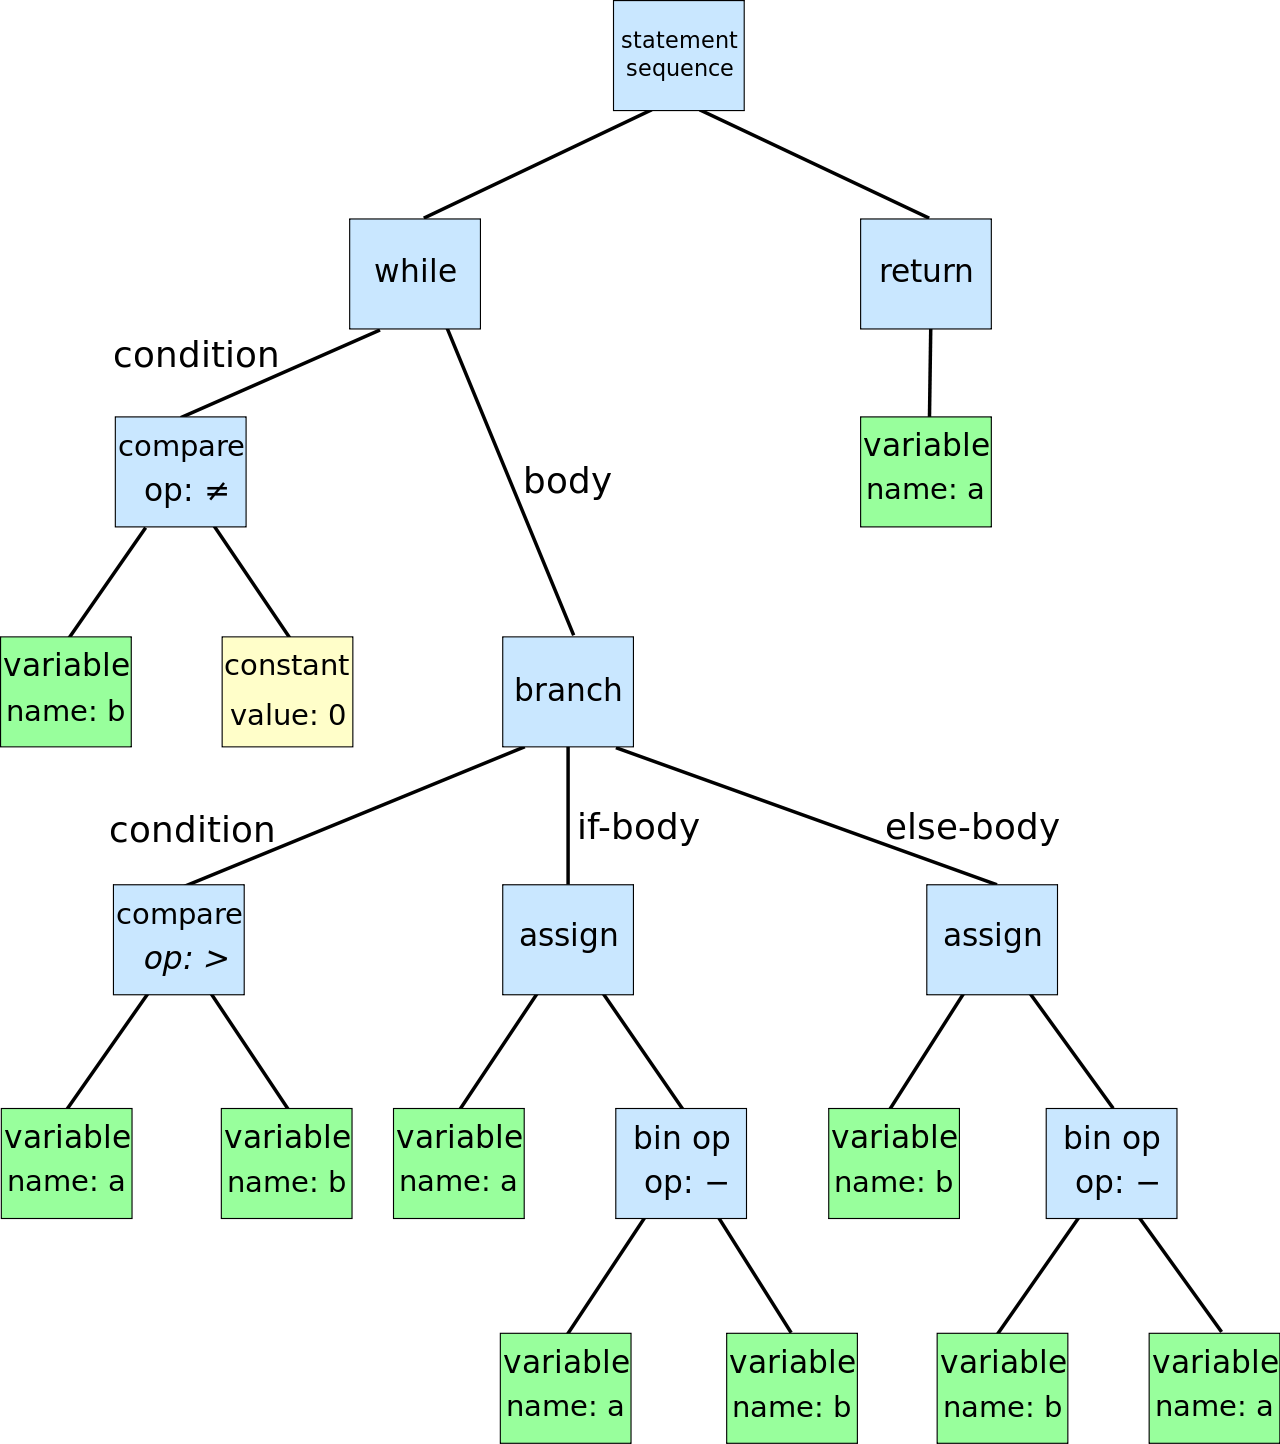

### Parsing code into an AST

If we leverage the programming code information, can we improve the performance of the augograding?

Let's first parse all code into ASTs -- but what if a code is not parsible?

In [30]:
!pip install javalang anytree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.8 MB/s eta 0:00:00


In [31]:
import javalang
from anytree import Node, RenderTree
from anytree.search import findall_by_attr
from anytree.walker import Walker

# List the functions we want to have in our parsing
function_string_list = ["public", "int", "=", "+", "-", "*", "/", "//", "&&", "||", "==", ">=", "<=", "<", ">",
                       "return", "true", "false", "else", "String", "!=", "+=", "-=", "*=", "/=",
                       "length", "substring", "indexOf", "startsWith", "endsWith", "StringBuilder", "contains",
                       "append", "for", "++", "chatAt", "equals", "toLowerCase", "lastIndexOf", ":",
                       "int[]", "new", "[]"]

# This code takes a node of parsed Java into token
def get_token(node):
    token = ''
    if isinstance(node, str):
        if not node.isnumeric() and (node not in function_string_list):
            token = "node"
        else:
            token = node
    elif isinstance(node, set):
        token = 'Modifier'  # node.pop()
    elif isinstance(node, javalang.ast.Node):
        token = node.__class__.__name__

    return token

# This code expands the java tree into
def get_children(root):
    if isinstance(root, javalang.ast.Node):
        children = root.children
    elif isinstance(root, set):
        children = list(root)
    else:
        children = []

    def expand(nested_list):
        for item in nested_list:
            if isinstance(item, list):
                for sub_item in expand(item):
                    yield sub_item
            elif item:
                yield item

    return list(expand(children))

# Recursively build "anytree" structure with the node.
def get_trees(current_node, parent_node, order):

    token, children = get_token(current_node), get_children(current_node)
    node = Node([order,token], parent=parent_node, order=order)

    for child_order in range(len(children)):
        get_trees(children[child_order], node, order+str(int(child_order)+1))

# Java parser of program
def program_parser(func):
    tokens = javalang.tokenizer.tokenize(func)
    parser = javalang.parser.Parser(tokens)
    tree = parser.parse_member_declaration()
    return tree

In [32]:
# Test the code

# Find a submission to parse
raw_java_code = train_df['Code'].iloc[1]
# Using Java parser
java_code = program_parser(raw_java_code)

# Initialize head node of the code.
head = Node(["1",get_token(java_code)])

# Recursively construct AST tree.
for child_order in range(len(get_children(java_code))):
    get_trees(get_children(java_code)[child_order], head, "1"+str(int(child_order)+1))

# Visualization of the tree
from anytree.exporter import DotExporter
DotExporter(head).to_picture('vis.png')

In [33]:
print(raw_java_code)

public int sortaSum(int a, int b)
{
    int sum = a + b;
	if(sum >= 10 && sum <= 19)
		return 20;
	return sum;
}






It will return a image like this:

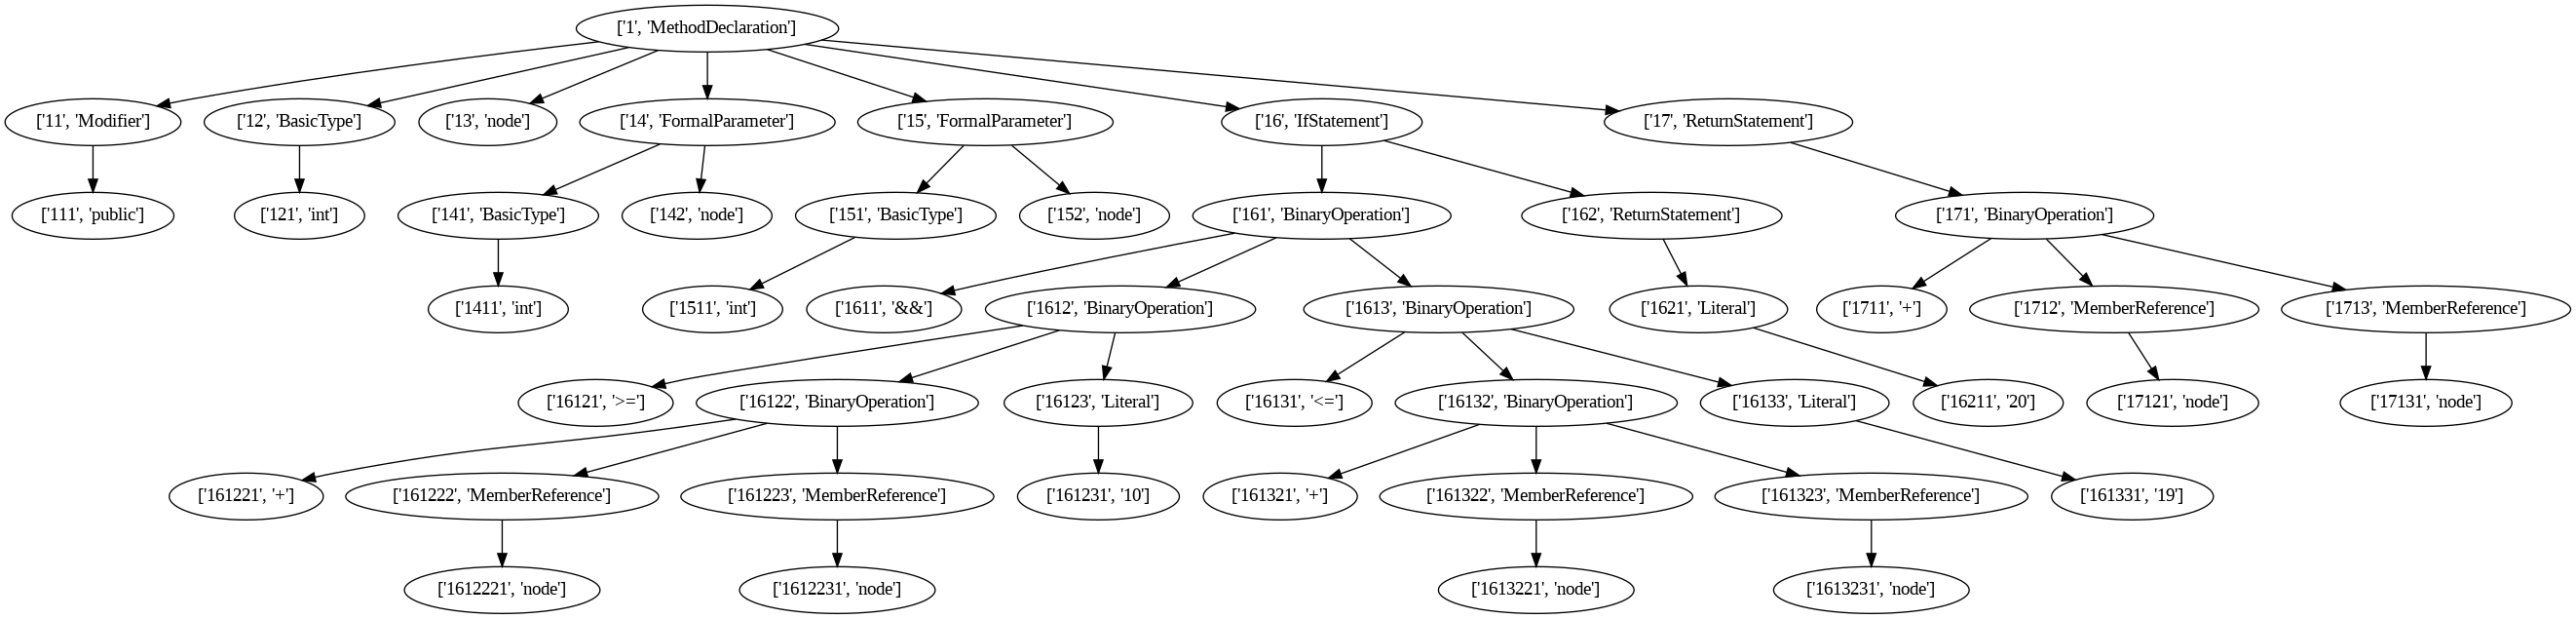

## 3.2 Implementing code2vec for autograding

### The code2vec Model & Attention Mechanism

The code2vec model is a model developed by Alon et al. in 2019 [1]. It leverages code structure for the classification of programming code function name in industrial code, and now used widely as base models.

[Model demo](https://code2vec.org/)


[1] Alon, Uri, et al. "code2vec: Learning distributed representations of code." Proceedings of the ACM on Programming Languages 3.POPL (2019): 1-29.

One key innovation of the paper is to leverage the soft attention mechanism to show which code path is more important. Below is the structure of the model:

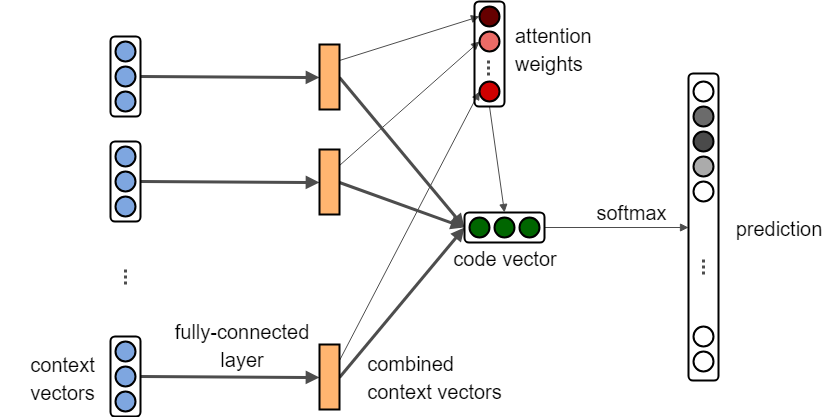

### A code2vec Implementation with PyTorch

In [34]:
import random # For genearting hash code

# Some util functions
def get_path_length(path):
    """Calculating path length.
    Input:
    path: list. Containing full walk path.

    Return:
    int. Length of the path.
    """

    return len(path)

def get_path_width(raw_path):
    """Calculating path width.
    Input:
    raw_path: tuple. Containing upstream, parent, downstream of the path.

    Return:
    int. Width of the path.
    """

    return abs(int(raw_path[0][-1].order)-int(raw_path[2][0].order))

def hashing_path(path, hash_table):
    """Calculating path width.
    Input:
    raw_path: tuple. Containing upstream, parent, downstream of the path.

    Return:
    str. Hash of the path.
    """

    if path not in hash_table:
        hash = random.getrandbits(128)
        #print(path)
        hash_table[path] = str(hash)
        return str(hash)
    else:
        return hash_table[path]

def get_node_rank(node_name, max_depth):
    """Calculating node rank for leaf nodes.
    Input:
    node_name: list. where the first element is the string order of the node, second element is actual name.
    max_depth: int. the max depth of the code.

    Return:
    list. updated node name list.
    """
    while len(node_name[0]) < max_depth:
        node_name[0] += "0"
    return [int(node_name[0]),node_name[1]]

def extracting_path(java_code, max_length, max_width, hash_path, hashing_table):
    """Extracting paths for a given java code.
    Input:
    java_code: parsed java code.
    max_length: int. Max length of the path to be restained.
    max_width: int. Max width of the path to be restained.
    hash_path: boolean. if true, MD5 hashed path will be returned to save space.
    hashing_table: Dict. Hashing table for path.

    Return:
    walk_paths: list of AST paths from the Java code.
    """

    # Initialize head node of the code.
    head = Node(["1",get_token(java_code)])

    # Recursively construct AST tree.

    for child_order in range(len(get_children(java_code))):

        get_trees(get_children(java_code)[child_order], head, "1"+str(int(child_order)+1))

    # Getting leaf nodes.
    leaf_nodes = findall_by_attr(head, name="is_leaf", value=True)

    # Getting max depth.
    max_depth = max([len(node.name[0]) for node in leaf_nodes])

    # Node rank modification.
    for leaf in leaf_nodes:
        leaf.name = get_node_rank(leaf.name,max_depth)

    walker = Walker()
    text_paths = []
    origin_paths = []

    # Walk from leaf to target
    for leaf_index in range(len(leaf_nodes)-1):
        for target_index in range(leaf_index+1, len(leaf_nodes)):
            # Walk
            raw_path = walker.walk(leaf_nodes[leaf_index], leaf_nodes[target_index])

            # Combining up and down streams
            walk_path = [n.name[1] for n in list(raw_path[0])]+[raw_path[1].name[1]]+[n.name[1] for n in list(raw_path[2])]
            # Deliminating paths, using some rare chars as deliminator
            text_path = "\U0001f972".join(walk_path)

            # Only keeping satisfying paths.
            if get_path_length(walk_path) <= max_length and get_path_width(raw_path) <= max_width:
                if not hash_path:
                # If not hash path, then output original text path.
                    text_paths.append(walk_path[0]+","+text_path+","+walk_path[-1])
                else:
                # If hash, then output hashed path.
                    text_paths.append(walk_path[0]+","+hashing_path(text_path, hashing_table)+","+walk_path[-1])
                    origin_paths.append(walk_path[0]+","+text_path+","+walk_path[-1])

    return text_paths

It's actually the emoji (that is unlikely to show up in students' code):

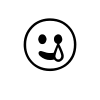

In [35]:
# Go through all data to check parsable and unparsable code
parsed_code = []
for c in list(data_df['Code']):
    try:
        parsed = program_parser(c)
    except:
        parsed = "Unparsable"
    parsed_code.append(parsed)
data_df['Parsed Code'] = parsed_code

parsed_data_df = data_df[data_df['Parsed Code'] != "Unparsable"]

parsed_data_df.head()

,CodeStateID,Score,Code,Parsed Code
0,5c3b1a18d738139379a040695b382bb8a44f0be2302fa7...,1,"public int sortaSum(int a, int b)\r\n{\r\n ...","MethodDeclaration(annotations=[], body=[IfStat..."
1,79c9e2da9bc703116d8768297056db22866c43d583e529...,1,"public int sortaSum(int a, int b)\r\n{\r\n ...","MethodDeclaration(annotations=[], body=[LocalV..."
2,f0e82004a47ecfe42eee5197644ef293ee048b17e6793f...,1,"public int sortaSum(int a, int b)\r\n{\r\n ...","MethodDeclaration(annotations=[], body=[LocalV..."
3,151d4daa86e0cfebb16a310036c7786a342343ab7be162...,1,"public int sortaSum(int a, int b)\r\n{\r\n ...","MethodDeclaration(annotations=[], body=[IfStat..."
4,eb66469c9b694a9950e6acf2dd99d11bcd11d4237d1da6...,1,"public int sortaSum(int a, int b)\r\n{\r\n ...","MethodDeclaration(annotations=[], body=[LocalV..."


In [36]:
# Initialize hashing_table.
hashing_table = {}
#hashing_table = np.load("path_hashing_dict.npy",allow_pickle=True).item()

# Extracting paths for all programs in the csv file. Output is [["start,path_hash,end",...,...],...].
AST_paths = []
origin_AST_paths = []
for java_code in parsed_data_df['Parsed Code']:
    text_paths = extracting_path(java_code, max_length=8, max_width=2, hash_path=True, hashing_table=hashing_table)
    AST_paths.append(text_paths)

# Storing the raw paths
parsed_data_df["RawASTPath"] = ["\U0001f972".join(A) for A in AST_paths]

print(parsed_data_df["RawASTPath"].iloc[0])

public,206337408036700629525472879044998276151,int🥲public,327489286632662375548365111298651454444,node🥲int,305163697004979305212155113371206985979,node🥲int,73665984565182963975576338939964811599,int🥲int,234310095809270483966711750837412308025,node🥲node,153781424641800738239392265101281140694,int🥲node,188657317367129656495341715579422200162,node🥲node,153781424641800738239392265101281140694,int🥲node,188657317367129656495341715579422200162,node🥲int,165628208476239301159893088237159555396,node🥲int,239065778986660103294771613188089551046,int🥲int,216533985950085918233598121185923286662,node🥲int,26089666299110820485318694659008729682,&&🥲int,189098112539349792842777661214331135985,>=🥲int,128319225959074495673696402723480196031,<=🥲node,216697973183789899747813877504649562603,int🥲node,308985114065888316644659862388589635171,node🥲node,305357659130966767512614831353887678329,&&🥲node,96113777822454365674074014529508098900,>=🥲node,85072281954639354954812977087602324702,+🥲node,13637038019668926469316

<ipython-input-36-c2b6775b2eac>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_data_df["RawASTPath"] = ["\U0001f972".join(A) for A in AST_paths]


<Axes: ylabel='Code'>

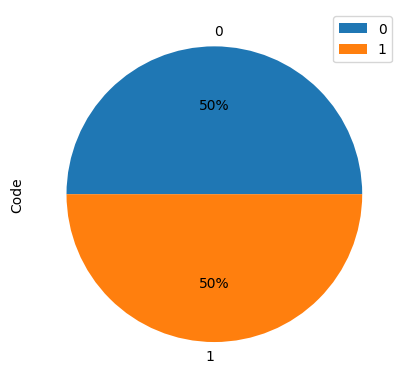

In [37]:
# Split the dataset into training and testing with a 4:1 ratio.
train_df, test_df = train_test_split(parsed_data_df, test_size=0.2)

# Plotting a pie chart of score distribution
train_df.groupby(['Score']).count().plot(kind='pie', y='Code', autopct='%1.0f%%')

# Now we can see the change of distribution -- surely they are incorrect code.

In [38]:
# Util functions regarding indexing the paths and nodes
def create_word_index_table(vocab):
    """
    Creating word to index table
    Input:
    vocab: list. The list of the node vocabulary

    """
    ixtoword = {}
    # period at the end of the sentence. make first dimension be end token
    ixtoword[0] = 'END'
    ixtoword[1] = 'UNK'
    wordtoix = {}
    wordtoix['END'] = 0
    wordtoix['UNK'] = 1
    ix = 2
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1
    return wordtoix, ixtoword

def convert_to_idx(sample, node_word_index, path_word_index):
    """
    Converting to the index
    Input:
    sample: list. One single training sample, which is a code, represented as a list of neighborhoods.
    node_word_index: dict. The node to word index dictionary.
    path_word_index: dict. The path to word index dictionary.

    """
    sample_index = []
    for line in sample.split("\U0001f972"):
        components = line.split(",")
        if components[0] in node_word_index:
            starting_node = node_word_index[components[0]]
        else:
            starting_node = node_word_index['UNK']
        if components[1] in path_word_index:
            path = path_word_index[components[1]]
        else:
            path = path_word_index['UNK']
        if components[2] in node_word_index:
            ending_node = node_word_index[components[2]]
        else:
            ending_node = node_word_index['UNK']

        sample_index.append([starting_node,path,ending_node])
    return sample_index

In [39]:
# To unpack a path set from a code submission.
print(train_df["RawASTPath"].iloc[0].split("\U0001f972"))

['public,206337408036700629525472879044998276151,int', 'public,327489286632662375548365111298651454444,node', 'int,305163697004979305212155113371206985979,node', 'int,73665984565182963975576338939964811599,int', 'int,234310095809270483966711750837412308025,node', 'node,153781424641800738239392265101281140694,int', 'node,188657317367129656495341715579422200162,node', 'node,153781424641800738239392265101281140694,int', 'node,188657317367129656495341715579422200162,node', 'int,165628208476239301159893088237159555396,node', 'int,239065778986660103294771613188089551046,int', 'int,216533985950085918233598121185923286662,node', 'int,26089666299110820485318694659008729682,&&', 'int,189098112539349792842777661214331135985,>=', 'int,128319225959074495673696402723480196031,<=', 'int,66635743445557781094195610523534307296,+', 'int,126543888999126431528482466968935891663,&&', 'node,216697973183789899747813877504649562603,int', 'node,308985114065888316644659862388589635171,node', 'node,3053576591309

In [40]:
node_hist = {}
path_hist = {}

# Creating dictionarys of paths and nodes in training set.
for paths in train_df["RawASTPath"]:
    # Unpack paths
    for text_path in paths.split("\U0001f972"):
        s = text_path.split(",")[0]
        p = text_path.split(",")[1]
        e = text_path.split(",")[2]
        nodes = [s] + [e]
        for n in nodes:
            if not n in node_hist:
                node_hist[n] = 1
            else:
                node_hist[n] += 1
        if not p in path_hist:
            path_hist[p] = 1
        else:
            path_hist[p] += 1

node_count = len(node_hist)
path_count = len(path_hist)

# small frequency then abandon, for node and path
valid_node = [node for node, count in node_hist.items()]
valid_path = [path for path, count in path_hist.items()]

# create ixtoword and wordtoix lists
node_word_index, node_index_word = create_word_index_table(valid_node)
path_word_index, path_index_word = create_word_index_table(valid_path)

train_converted_data = [convert_to_idx(sample, node_word_index, path_word_index) for
                        sample in train_df["RawASTPath"]]

test_converted_data = [convert_to_idx(sample, node_word_index, path_word_index) for
                        sample in test_df["RawASTPath"]]

In [41]:
# How do our dictionary look like?
print(node_word_index)

{'END': 0, 'UNK': 1, 'public': 2, 'int': 3, 'node': 4, '&&': 5, '>=': 6, '<=': 7, '+': 8, '0': 9, '10': 10, '>': 11, '<': 12, '20': 13, '19': 14, '=': 15, '9': 16, '21': 17, '||': 18, 'true': 19, 'BlockStatement': 20, '13': 21, 'false': 22, '==': 23, '/=': 24, 'ReturnStatement': 25, '!=': 26, '16': 27, '17': 28, '18': 29, '15': 30, '14': 31, '12': 32, '11': 33, '-': 34, '*': 35, '30': 36, 'BreakStatement': 37, '1': 38}


In [42]:
# Indices to be fed to the code2vec model.
print(train_converted_data[0])

[[2, 2, 3], [2, 3, 4], [3, 4, 4], [3, 5, 3], [3, 6, 4], [4, 7, 3], [4, 8, 4], [4, 7, 3], [4, 8, 4], [3, 9, 4], [3, 10, 3], [3, 11, 4], [3, 12, 5], [3, 13, 6], [3, 14, 7], [3, 15, 8], [3, 16, 5], [4, 17, 3], [4, 18, 4], [4, 19, 5], [4, 20, 6], [4, 21, 8], [4, 22, 9], [4, 23, 7], [4, 21, 8], [4, 24, 10], [4, 25, 8], [4, 26, 4], [4, 26, 4], [4, 27, 5], [4, 28, 11], [4, 29, 12], [4, 30, 13], [3, 9, 4], [3, 12, 5], [3, 13, 6], [3, 14, 7], [3, 15, 8], [3, 16, 5], [4, 19, 5], [4, 20, 6], [4, 21, 8], [4, 22, 9], [4, 23, 7], [4, 21, 8], [4, 24, 10], [4, 25, 8], [4, 26, 4], [4, 26, 4], [4, 27, 5], [4, 28, 11], [4, 29, 12], [4, 30, 13], [5, 31, 6], [5, 32, 8], [5, 33, 4], [5, 33, 4], [5, 34, 9], [5, 35, 7], [5, 32, 8], [5, 33, 4], [5, 33, 4], [5, 36, 10], [5, 37, 8], [5, 38, 4], [5, 38, 4], [5, 39, 5], [5, 40, 11], [5, 41, 8], [5, 42, 10], [5, 43, 12], [5, 41, 8], [5, 44, 14], [5, 45, 13], [6, 46, 8], [6, 47, 4], [6, 47, 4], [6, 48, 9], [6, 49, 7], [6, 50, 8], [6, 51, 4], [6, 51, 4], [6, 52, 10],

In [43]:
class code2vec(nn.Module):
    """
    Defining the code2vec network.

    """
    def __init__(self, node_count, path_count):
        super(code2vec, self).__init__()
        self.embed_nodes = nn.Embedding(node_count+2, 100) # adding unk and end
        self.embed_paths = nn.Embedding(path_count+2, 100) # adding unk and end
        self.embed_dropout = nn.Dropout(0.2)
        self.path_transformation_layer = nn.Linear(300,300)
        self.attention_layer = nn.Linear(300,1)
        self.prediction_layer = nn.Linear(300,1)
        self.attention_softmax = nn.Softmax(dim=1)
        self.classification_layer = nn.Sigmoid()
        self.sigmoid_layer = nn.Sigmoid()
    def forward(self, starting_node_index, ending_node_index, path_index, evaluating=False):
        '''
        Parameters:
        batch: b
        codes: c (non-unified)
        node_embeddings: ne
        path_embeddings: pe

        '''
        starting_node_embed = self.embed_nodes(starting_node_index) # (b,c,1) -> (b,c,ne)
        ending_node_embed = self.embed_nodes(ending_node_index) # (b,c,1) -> (b,c,ne)
        path_embed = self.embed_paths(path_index) # (b,c,1) -> (b,c,pe)
        full_embed = torch.cat((starting_node_embed, ending_node_embed,
                                path_embed), dim=2) # (b,c,2ne+pe)
        if not evaluating:
            full_embed = self.embed_dropout(full_embed) # (b,c,2ne+pe)
        full_embed_transformed = torch.tanh(self.path_transformation_layer(
            full_embed)) # (b,c,2ne+pe)
        context_weights = self.attention_layer(full_embed_transformed) # (b,c,1)
        attention_weights = self.attention_softmax(context_weights) # (b,c,1)
        code_vectors = torch.sum(torch.mul(full_embed,attention_weights),
                                 dim=1) # (b,2ne+pe)
        predictions = self.sigmoid_layer(self.prediction_layer(code_vectors)) # (b,1)
        return predictions

    def padding(self, index_list):
        """
        Padding the neighborhoods and the code.

        """
        padder_index = 0
        max_length = 100
        padded_list = []
        for sample in index_list:

            if max_length > len(sample):
                # padding the paths, or just get the first "max_gram_length" of paths
                padding_length = max_length - len(sample)
                padded_list.append(sample + [padder_index]*padding_length)
            else:
                padded_list.append(sample[:max_length])

        return padded_list

In [44]:
# Define the hyperparameters of model training
lr = 0.01 # Learning rate
epochs = 20 # Training epochs

# Initialize model
model = code2vec(node_count, path_count)

# We use binary cross entropy as the loss
loss_func = nn.BCELoss()

# Using Adam as the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Putting labels in tensors
y_train = torch.Tensor(train_df['Score'].values)
y_test = torch.Tensor(test_df['Score'].values)

# Repeat the learning process for the number of epochs
for e in range(epochs):
    # Creating padded tensors for input: nodes and paths
    starting_node_index = torch.LongTensor(
        model.padding([[p[0] for p in single_sample] for
                       single_sample in train_converted_data]))
    ending_node_index = torch.LongTensor(
        model.padding([[p[2] for p in single_sample] for
                         single_sample in train_converted_data]))
    path_index = torch.LongTensor(
        model.padding([[p[1] for p in single_sample] for
                  single_sample in train_converted_data]))


    # Forward pass
    predictions = model(starting_node_index, ending_node_index, path_index)
    # Calculate the loss -- the squeeze ensures the dimensions are consistent
    loss = loss_func(torch.squeeze(predictions), y_train)

    # Model clean gradient
    optimizer.zero_grad()
    # Model backward pass to get the gradient
    loss.backward()
    # Model updating weights
    optimizer.step()

    # Print the training process
    print("Epoch:", e, "loss:", loss.item())

Epoch: 0 loss: 0.695962131023407
Epoch: 1 loss: 0.6606827974319458
Epoch: 2 loss: 0.6128144264221191
Epoch: 3 loss: 0.5673549175262451
Epoch: 4 loss: 0.5385879874229431
Epoch: 5 loss: 0.5212302803993225
Epoch: 6 loss: 0.49945250153541565
Epoch: 7 loss: 0.4820442199707031
Epoch: 8 loss: 0.46126046776771545
Epoch: 9 loss: 0.43192270398139954
Epoch: 10 loss: 0.40957942605018616
Epoch: 11 loss: 0.41680094599723816
Epoch: 12 loss: 0.3915320038795471
Epoch: 13 loss: 0.3661152422428131
Epoch: 14 loss: 0.3584406077861786
Epoch: 15 loss: 0.3478412330150604
Epoch: 16 loss: 0.32318314909935
Epoch: 17 loss: 0.33249202370643616
Epoch: 18 loss: 0.31638792157173157
Epoch: 19 loss: 0.32655104994773865


In [45]:
# Evaluation on the Testing set

starting_node_index = torch.LongTensor(
        model.padding([[p[0] for p in single_sample] for
                       single_sample in test_converted_data]))
ending_node_index = torch.LongTensor(
    model.padding([[p[2] for p in single_sample] for
                        single_sample in test_converted_data]))
path_index = torch.LongTensor(
    model.padding([[p[1] for p in single_sample] for
                single_sample in test_converted_data]))

y_pred = model(starting_node_index, ending_node_index, path_index)

# We'll need to use sklearn's metric calculation to calculate the accuracy for
# test dataset.

test_accuracy = metrics.accuracy_score(y_pred.detach().numpy().round(), y_test)

print(test_accuracy)

0.8341708542713567


### Why it's performing so much better?